In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
SIZE = 224
CLASSES = 53
EPOCHS = 20
PATIENCE_ES = 25
BATCH_SIZE = 32

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-02 17:31:04.121086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 17:31:04.121142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 17:31:04.122646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Cargar datos con Data Augmentation

In [4]:
# Data augmentation para MobileNet
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=(0.9, 1.1)
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_path = DATA_PATH + 'train'
valid_path = DATA_PATH + 'valid'
test_path = DATA_PATH + 'test'

train_dataset = train_generator.flow_from_directory(
    train_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = valid_generator.flow_from_directory(
    valid_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = test_generator.flow_from_directory(
    test_path,
    target_size=(SIZE, SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 7695 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


## Cargar modelo original y evaluar baseline

In [5]:
# Cargar modelo pre-entrenado
mn_pretrained = tf.keras.models.load_model('Models/MobileNet_2.h5')
print(f'Modelo cargado. Accuracy original en test:')
_, acc_original = mn_pretrained.evaluate(test_dataset, verbose=0)
print(f'Accuracy original: {acc_original:.4f}')

Modelo cargado. Accuracy original en test:
Accuracy original: 0.8642
Accuracy original: 0.8642


In [6]:
# Mostrar arquitectura original
mn_pretrained.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               8028288   
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 53)                3445      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape             

## Reconstruir modelo con mejoras

In [7]:
# Reconstruir MobileNetV2 con mas capas descongeladas
base_mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(SIZE, SIZE, 3)
)

print(f'Total capas en MobileNetV2: {len(base_mobilenet.layers)}')

# Descongelar desde la capa 100 (mas capas entrenables que antes)
for layer in base_mobilenet.layers[:100]:
    layer.trainable = False
for layer in base_mobilenet.layers[100:]:
    layer.trainable = True

trainable_count = sum([1 for layer in base_mobilenet.layers if layer.trainable])
print(f'Capas entrenables: {trainable_count}')

Total capas en MobileNetV2: 154
Capas entrenables: 54


In [8]:
# Arquitectura mejorada con BatchNormalization y regularizacion
inputs = tf.keras.layers.Input(shape=(SIZE, SIZE, 3))
x = base_mobilenet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Mejor que Flatten
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

mn_improved = tf.keras.Model(inputs=inputs, outputs=outputs)
mn_improved.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                             

In [9]:
# Contar parametros
trainable_params = np.sum([np.prod(v.shape) for v in mn_improved.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in mn_improved.non_trainable_variables])
print(f'Parametros entrenables: {trainable_params:,}')
print(f'Parametros no entrenables: {non_trainable_params:,}')

Parametros entrenables: 2,231,669
Parametros no entrenables: 399,104


## Entrenar con AdamW (weight decay)

In [10]:
name = 'MobileNet_3'

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [11]:
# Compilar con AdamW (weight decay integrado)
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5
)

# Label smoothing para mejor generalizacion
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

mn_improved.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

In [23]:
# Entrenar
history_adamw = mn_improved.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.9544
Epoch 1: val_accuracy did not improve from 0.93962

Epoch 1: val_accuracy did not improve from 0.93962
241/241 [==============================] - 78s 322ms/step - loss: 1.0789 - accuracy: 0.9544 - val_loss: 1.0867 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 2/20
241/241 [==============================] - 78s 322ms/step - loss: 1.0789 - accuracy: 0.9544 - val_loss: 1.0867 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 1.0734 - accuracy: 0.9570
Epoch 2: val_accuracy did not improve from 0.93962

Epoch 2: val_accuracy did not improve from 0.93962
241/241 [==============================] - 73s 303ms/step - loss: 1.0734 - accuracy: 0.9570 - val_loss: 1.0775 - val_accuracy: 0.9170 - lr: 1.0000e-04
Epoch 3/20
241/241 [==============================] - 73s 303ms/step - loss: 1.0734 - accuracy: 0.9570 - val_loss: 1.0775 - val_accuracy: 

## Visualizar resultados

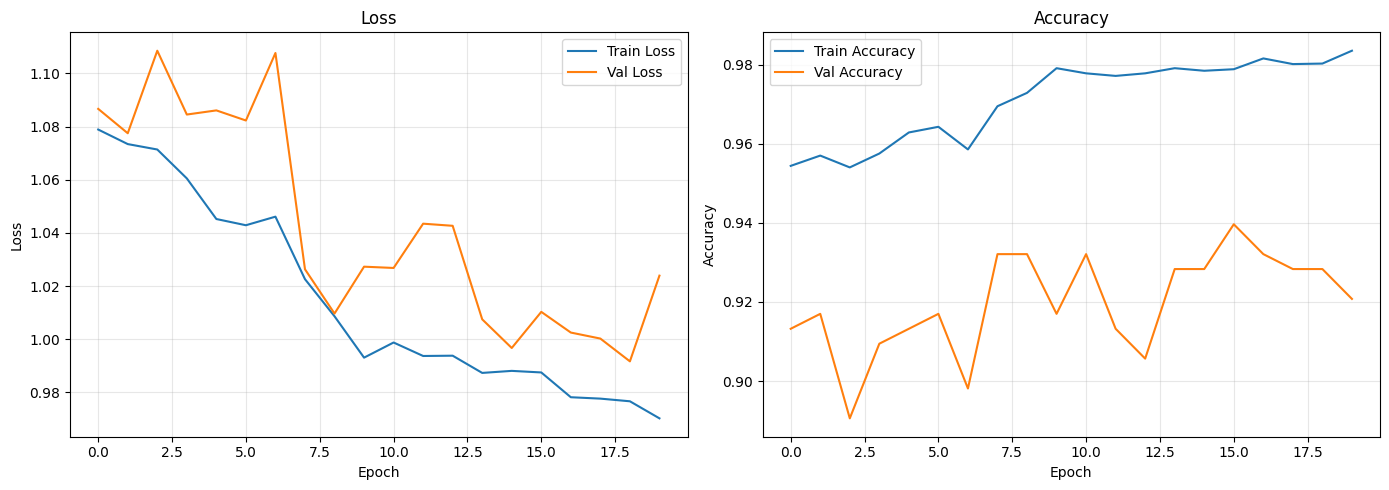

In [24]:
def plot_and_save(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history_df['epoch'], history_df['accuracy'], label='Train Accuracy')
    axes[1].plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_and_save(history_adamw, path_results, name)

## Experimento alternativo: SGD con momentum

In [14]:
# Reconstruir modelo para SGD
base_mobilenet_sgd = tf.keras.applications.MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(SIZE, SIZE, 3)
)

for layer in base_mobilenet_sgd.layers[:100]:
    layer.trainable = False
for layer in base_mobilenet_sgd.layers[100:]:
    layer.trainable = True

inputs_sgd = tf.keras.layers.Input(shape=(SIZE, SIZE, 3))
x = base_mobilenet_sgd(inputs_sgd)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs_sgd = tf.keras.layers.Dense(CLASSES, activation='softmax')(x)

mn_sgd = tf.keras.Model(inputs=inputs_sgd, outputs=outputs_sgd)

In [15]:
name_sgd = 'MobileNet_3_SGD'

checkpoint_sgd = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name_sgd + '.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks_sgd = [checkpoint_sgd, early_stop, reduce_lr]

# SGD con momentum y Nesterov
optimizer_sgd = tf.keras.optimizers.SGD(
    learning_rate=1e-3,
    momentum=0.9,
    nesterov=True
)

mn_sgd.compile(
    optimizer=optimizer_sgd,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.8495
Epoch 1: val_accuracy did not improve from 0.90566

Epoch 1: val_accuracy did not improve from 0.90566
241/241 [==============================] - 67s 277ms/step - loss: 1.3731 - accuracy: 0.8495 - val_loss: 1.1815 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - 67s 277ms/step - loss: 1.3731 - accuracy: 0.8495 - val_loss: 1.1815 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 1.3560 - accuracy: 0.8607
Epoch 2: val_accuracy did not improve from 0.90566
241/241 [==============================] - 64s 267ms/step - loss: 1.3560 - accuracy: 0.8607 - val_loss: 1.1864 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/20

Epoch 2: val_accuracy did not improve from 0.90566
241/241 [==============================] - 64s 267ms/step - loss: 1.3560 - accuracy: 0.8607 - val_loss: 1.1864 - val_accuracy: 0.8906 - lr:

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 [==============================] - 66s 273ms/step - loss: 1.2481 - accuracy: 0.8976 - val_loss: 1.0978 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 10/20
Epoch 10/20
241/241 [==============================] - ETA: 0s - loss: 1.2389 - accuracy: 0.8976
Epoch 10: val_accuracy did not improve from 0.90943
241/241 [==============================] - 67s 278ms/step - loss: 1.2389 - accuracy: 0.8976 - val_loss: 1.0984 - val_accuracy: 0.9057 - lr: 0.0010

Epoch 10: val_accuracy did not improve from 0.90943
241/241 [==============================] - 67s 278ms/step - loss: 1.2389 - accuracy: 0.8976 - val_loss: 1.0984 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 11/20
Epoch 11/20
241/241 [==============================] - ETA: 0s - loss: 1.2212 - accuracy: 0.9084
Epoch 11: val_accuracy improved from 0.90943 to 0.91698, saving model to Models/MobileNet_3_SGD.h5

Epoch 11: val_accuracy improved from 0.90943 to 0.91698, saving model to Models/MobileNet_3_SGD.h5
241/241 [============================

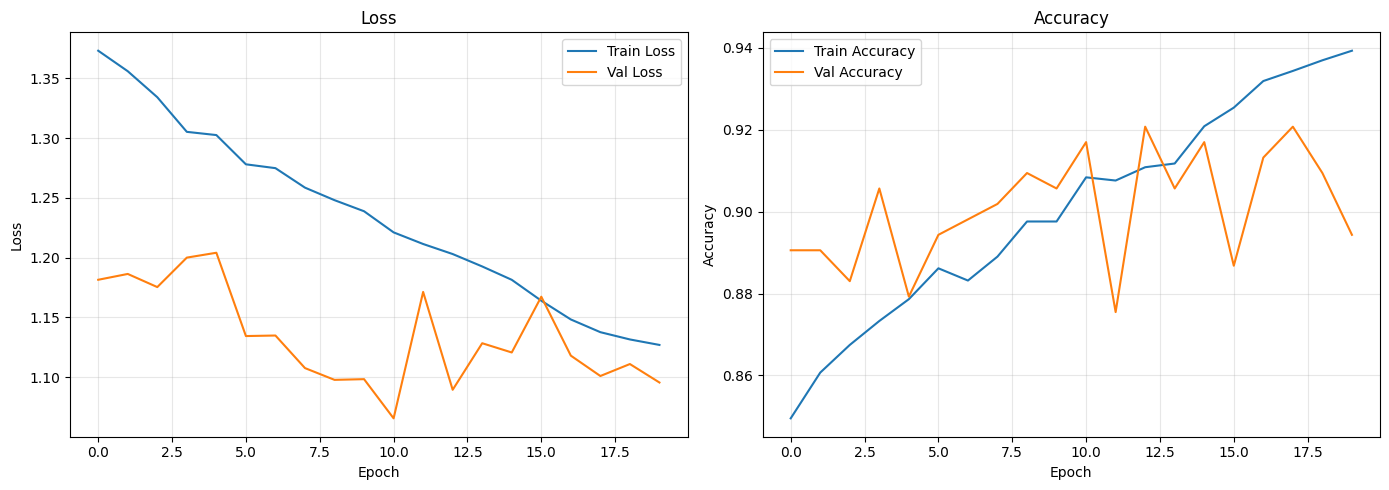

In [18]:
#Entrenar con SGD
history_sgd = mn_sgd.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_sgd
)
plot_and_save(history_sgd, path_results, name_sgd)

## Evaluacion en Test Set

In [25]:
# Cargar mejor modelo
best_model = tf.keras.models.load_model(os.path.join(path_models, name + '.h5'))
sgd_model = tf.keras.models.load_model(os.path.join(path_models, name_sgd + '.h5'))
# Evaluar
_, acc_improved = best_model.evaluate(test_dataset)
_, acc_sgd = sgd_model.evaluate(test_dataset)
print(f'\n=== Comparacion de resultados ===')
print(f'Accuracy original (MobileNet_2): {acc_original:.4f}')
print(f'Accuracy mejorado (MobileNet_3): {acc_improved:.4f}')
print(f'Accuracy con SGD: {acc_sgd:.4f}')
print(f'Mejora: {(acc_improved - acc_original)*100:.2f}%')


9/9 [==============================] - 1s 98ms/step - loss: 1.0395 - accuracy: 0.9321

=== Comparacion de resultados ===
Accuracy original (MobileNet_2): 0.8642
Accuracy mejorado (MobileNet_3): 0.9283
Accuracy con SGD: 0.9321
Mejora: 6.42%

=== Comparacion de resultados ===
Accuracy original (MobileNet_2): 0.8642
Accuracy mejorado (MobileNet_3): 0.9283
Accuracy con SGD: 0.9321
Mejora: 6.42%


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def show_report(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    print(classification_report(true_text, pred_text))

def show_matrix(model, dataframe):
    labels = dataframe.class_indices
    true_labels = dataframe.labels
    pred_labels = model.predict(dataframe, verbose=0).argmax(axis=1)
    keys_array = np.array(list(labels.keys()))
    true_text = [keys_array[value] for value in true_labels]
    pred_text = [keys_array[value] for value in pred_labels]
    cf = confusion_matrix(true_text, pred_text, labels=keys_array)
    fig, ax = plt.subplots(figsize=(14, 14))
    sns.heatmap(cf, annot=True, square=True, cbar=False,
                cmap=plt.cm.Blues, xticklabels=keys_array, yticklabels=keys_array, ax=ax,
                fmt='', linewidths=0.1)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

show_report(best_model, test_dataset)

                   precision    recall  f1-score   support

     ace of clubs       1.00      1.00      1.00         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       0.71      1.00      0.83         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      1.00      1.00         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       0.83      1.00      0.91         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      0.80      0.89       

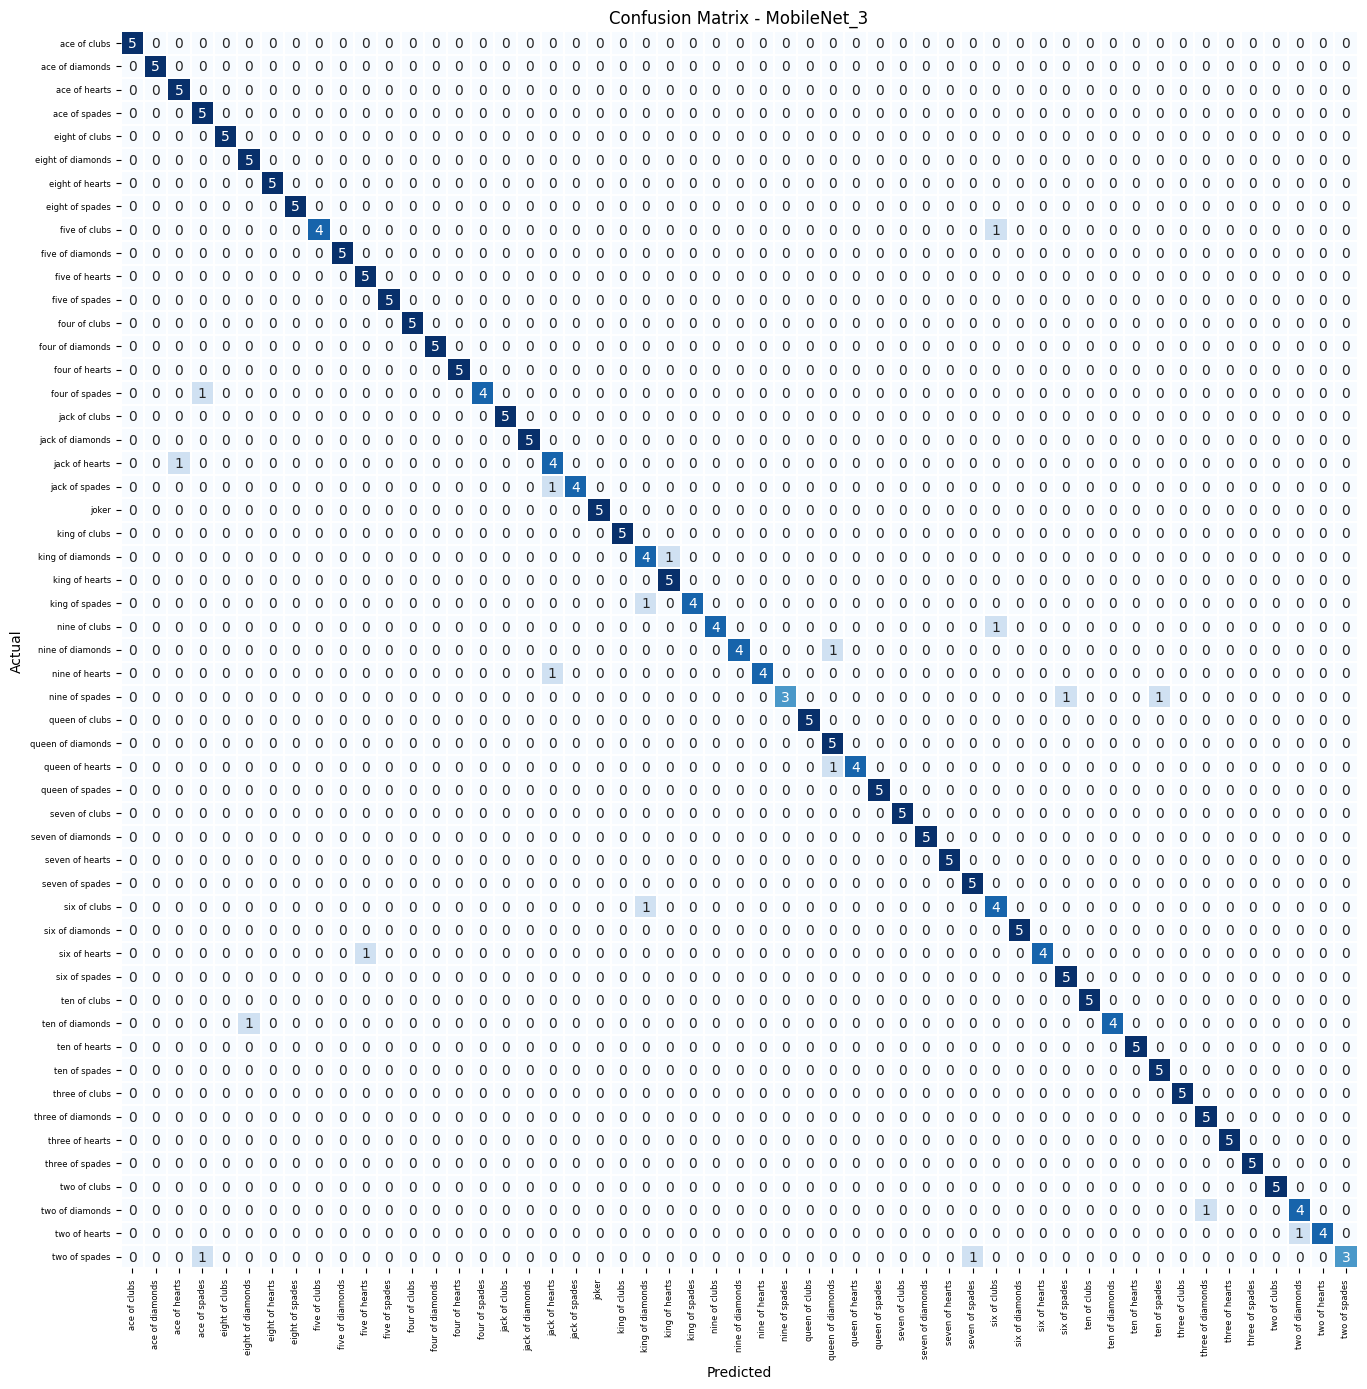

In [32]:
show_matrix(best_model, test_dataset)

In [33]:
show_report(sgd_model, test_dataset)

                   precision    recall  f1-score   support

     ace of clubs       0.83      1.00      0.91         5
  ace of diamonds       1.00      1.00      1.00         5
    ace of hearts       0.83      1.00      0.91         5
    ace of spades       1.00      1.00      1.00         5
   eight of clubs       1.00      1.00      1.00         5
eight of diamonds       0.83      1.00      0.91         5
  eight of hearts       1.00      1.00      1.00         5
  eight of spades       1.00      0.80      0.89         5
    five of clubs       1.00      0.80      0.89         5
 five of diamonds       1.00      1.00      1.00         5
   five of hearts       1.00      1.00      1.00         5
   five of spades       1.00      1.00      1.00         5
    four of clubs       1.00      1.00      1.00         5
 four of diamonds       1.00      1.00      1.00         5
   four of hearts       1.00      1.00      1.00         5
   four of spades       1.00      1.00      1.00       

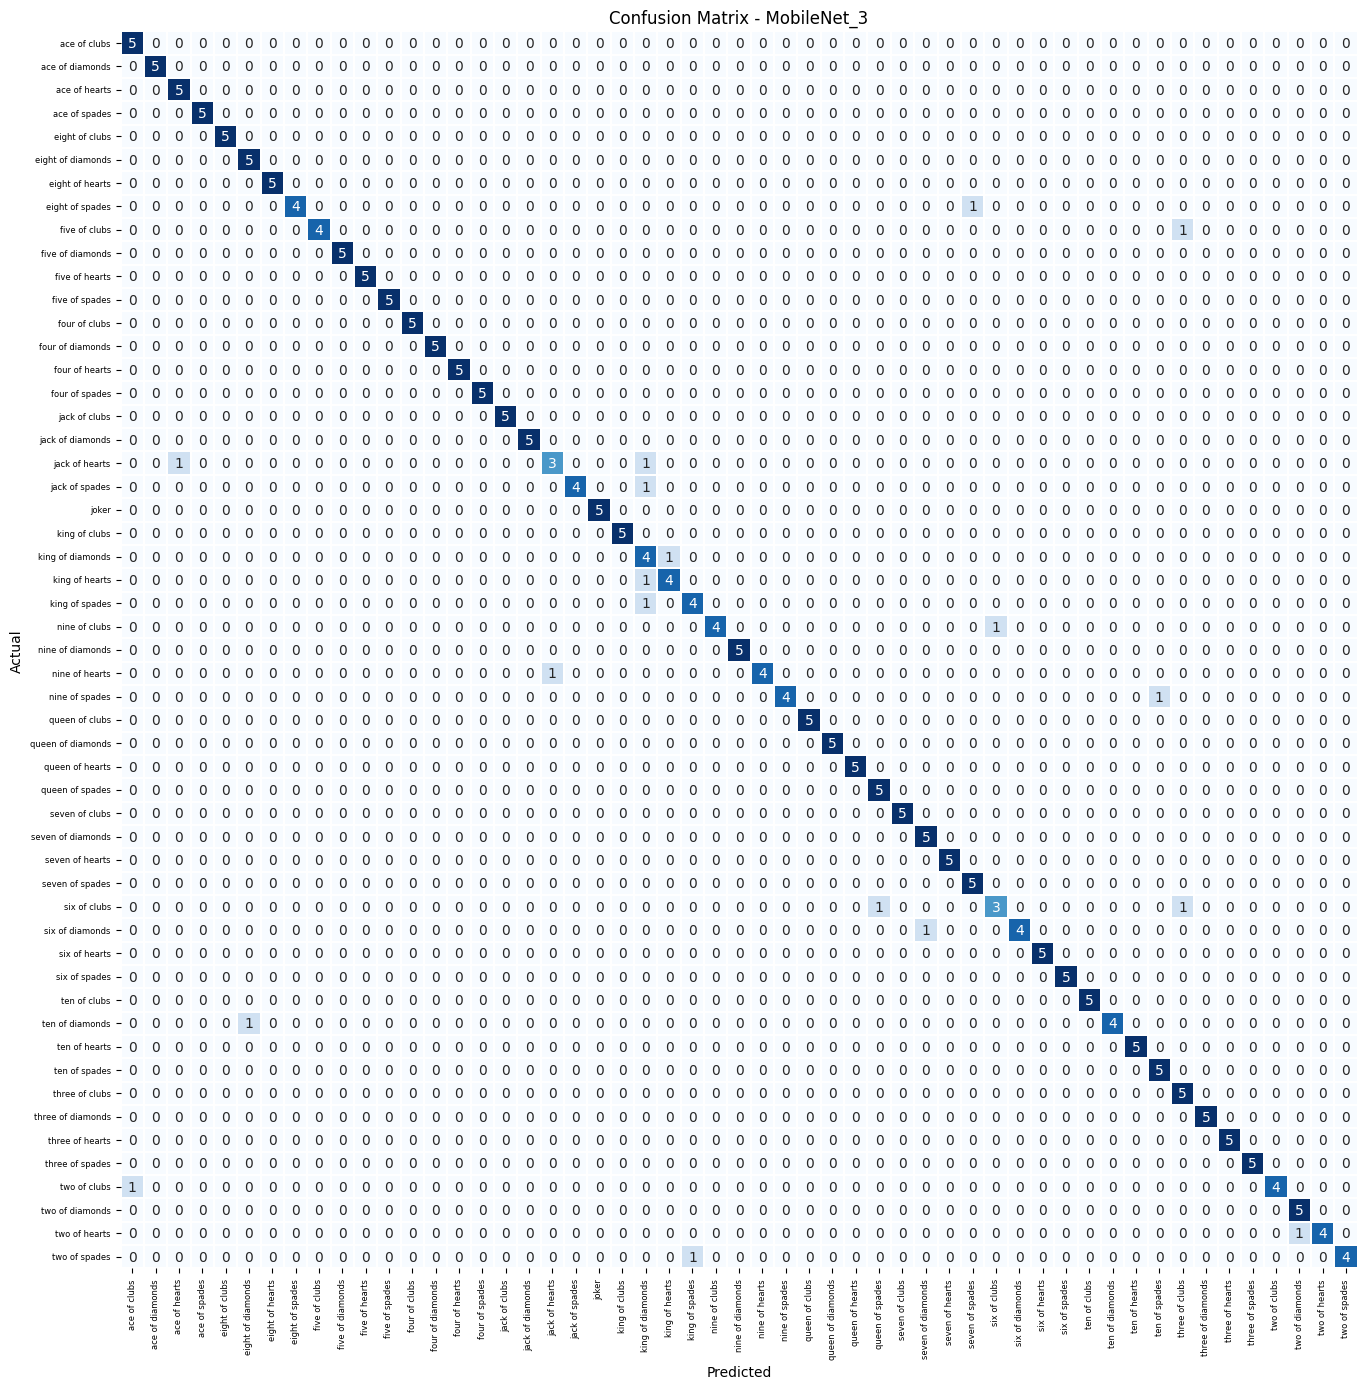

In [34]:
show_matrix(sgd_model, test_dataset)